# 0. Introduction

This project aims to analyze customer behavior and predict the likelihood of purchasing travel insurance. The dataset used originates from a travel insurance prediction study and contains customer demographic, financial, and travel-related features.

The primary objective of this analysis is to identify key factors influencing travel insurance purchases and develop machine learning models capable of accurately predicting customer decisions. This insight can support the travel company in better understanding their customer base and designing more effective marketing strategies for insurance coverage.

The target population in this study consists of customers of a travel company who have been presented with the option to purchase travel insurance. The dataset reflects a diverse range of customers with varying employment types, travel habits, and financial backgrounds. The goal is to uncover significant relationships among these features and the likelihood of purchasing travel insurance.

# 1. Loading libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
#from phik.report import plot_correlation_matrix
sns.set()
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
)
import statsmodels.api as sm
import scipy
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.kernel_approximation import Nystroem
from scipy.stats import uniform, randint
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import time
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score

In [2]:
custom_palette = ["#c89089", "#4a6fa5"]
c_red, c_blue = custom_palette[0], custom_palette[1]

In [3]:
df = pd.read_csv("TravelInsurancePrediction.csv", index_col=0)
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [4]:
df.shape

(1987, 9)

I'm going to normalize column names:

In [5]:
df.columns = ['Age', 'Employment Type', 'Graduate Or Not', 'Annual Income', 
              'Family Members', 'Chronic Diseases', 'Frequent Flyer', 
              'Ever Travelled Abroad', 'Travel Insurance']

# 2. Divide into training and test sets

Following best practices, I'll divide the dataset into two sets:
* Training set, containing 80% of the data, that will be used to train the different models.
* Test set, containing the other 20% of the data, that will be used to assess the accuracy of the best model.

I am dividing the original set in two sets as I will be using cross validation for tunning the model so, the training set will also contain the validation set.

Since the objective is to detect which customers have paid for the `TravelInsurance` I'll divide the sets stratifying on this feature to ensure that all of them hold the same proportion.

In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Descriptive statistics and sanity checks

## 3.1. Descriptive statistics
Let's find out the distribution of the variables:

In [8]:
# I'll merge back the training set for easier handling
data_train = pd.merge(X_train, y_train, left_index=True, right_index=True)
data_train.describe()

,Age,Annual Income,Family Members,Chronic Diseases,Travel Insurance
count,1589.000000,1.589000e+03,1589.000000,1589.000000,1589.000000
mean,29.604783,9.293266e+05,4.757080,0.275016,0.357458
std,2.913294,3.783027e+05,1.606864,0.446663,0.479402
min,25.000000,3.000000e+05,2.000000,0.000000,0.000000
25%,28.000000,6.000000e+05,4.000000,0.000000,0.000000
50%,29.000000,9.000000e+05,5.000000,0.000000,0.000000
75%,32.000000,1.250000e+06,6.000000,1.000000,1.000000
max,35.000000,1.800000e+06,9.000000,1.000000,1.000000


In [9]:
data_train.describe(include=object)

,Employment Type,Graduate Or Not,Frequent Flyer,Ever Travelled Abroad
count,1589,1589,1589,1589
unique,2,2,2,2
top,Private Sector/Self Employed,Yes,No,No
freq,1123,1349,1257,1291


In [10]:
cat_cols = selector(dtype_include=object)(data_train)
num_cols = selector(dtype_exclude=object)(data_train)

In [11]:
for cat_col in cat_cols:
    print(data_train[cat_col].value_counts(), "\n")

Employment Type
Private Sector/Self Employed    1123
Government Sector                466
Name: count, dtype: int64 

Graduate Or Not
Yes    1349
No      240
Name: count, dtype: int64 

Frequent Flyer
No     1257
Yes     332
Name: count, dtype: int64 

Ever Travelled Abroad
No     1291
Yes     298
Name: count, dtype: int64 



* As the **Age** column shows, the dataset is mainly focused on young adults, since the age ranges from 25 to 35 years and seems it is not skewed, since the mean and median are really close and the middle of the interval is also 30 years.
* The **AnnualIncome**  will present outliers as the mean is a bit higher than the median.
* **FamilyMembers** expand from 2 to 9 and seems to present some central tendency as well, as the mean and median are very close.
* **ChronicDiseases** is a categorical variable, identifying if the customer suffers from any chronic disease. From its distribution, we can see that around 27.5% of the customers suffered from any chronic disease.
* **Employment Type** has two categories: `Private Sector/Self Employed` and `Governmnent Sector`, being the former the most common in this dataset.
* **GraduateOrNot** most of the customers (nearly 85%) hold a college graduate.
* **FrequentFlyer** most of the customers aren't registered as frequent flyers (79.1%). 
* **EverTravelledAbroad** again, great majority of the customers haven't flown abroad (81.25%).
* **TravelInsurance** as shown in this column, 35.7% of the customers paid for the insurance cover.

## 3.2. Sanity checks

### 3.2.1. Duplicates
Let's look for duplicates in the dataset.

In [12]:
data_train[data_train.duplicated()]

,Age,Employment Type,Graduate Or Not,Annual Income,Family Members,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance
1274,34,Private Sector/Self Employed,Yes,1000000,3,0,No,No,0
589,26,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes,1
269,27,Private Sector/Self Employed,No,800000,5,0,No,No,0
353,31,Government Sector,No,300000,3,0,No,No,0
1349,26,Private Sector/Self Employed,Yes,1400000,3,0,No,Yes,1
...,...,...,...,...,...,...,...,...,...
1856,26,Private Sector/Self Employed,Yes,600000,3,0,Yes,No,0
755,29,Private Sector/Self Employed,Yes,1200000,4,0,No,No,0
1769,29,Private Sector/Self Employed,Yes,1050000,5,0,No,No,0
467,26,Government Sector,Yes,500000,5,0,No,No,0


The dataset presents 523 duplicates, it's not surprising, since the age column only covers 11 different values, and apart from `AnnualIncome`, the rest of the features only have two possible values. In this case, it is important to keep all the data as it is.

### 3.2.2. Missing values

Let's see if there are missing values in this dataset:

In [13]:
missing_count = data_train.isnull().sum()
value_count = data_train.isnull().count()
missing_perc = round(missing_count / value_count * 100, 2)
missing_df = pd.DataFrame({"Missing values": missing_count, "Percentage": missing_perc})
missing_df

,Missing values,Percentage
Age,0,0.0
Employment Type,0,0.0
Graduate Or Not,0,0.0
Annual Income,0,0.0
Family Members,0,0.0
Chronic Diseases,0,0.0
Frequent Flyer,0,0.0
Ever Travelled Abroad,0,0.0
Travel Insurance,0,0.0


None of the columns have missing values, and the descriptive statistics didn't show any sign that led us to think that missing values were imputed using an extreme value.

### 3.2.3. Outliers
Let's move to look for outliers. The dataset only has three actual numerical columns that this inspection can be done `Age`, `AnnualIncome` and `FamilyMembers`; `Age` and `FamilyMembers` have a small range and the aim of detecting outliers is to identify if those should be removed to prevent the model from learning from extreme cases, which can be detrimental specially for linear models. I won't be removing any value of these two columns, since they hold meaningful information. So I will only inspect `AnnualIncome`.

In [14]:
Q1 = data_train["Annual Income"].quantile(0.25)
Q3 = data_train["Annual Income"].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

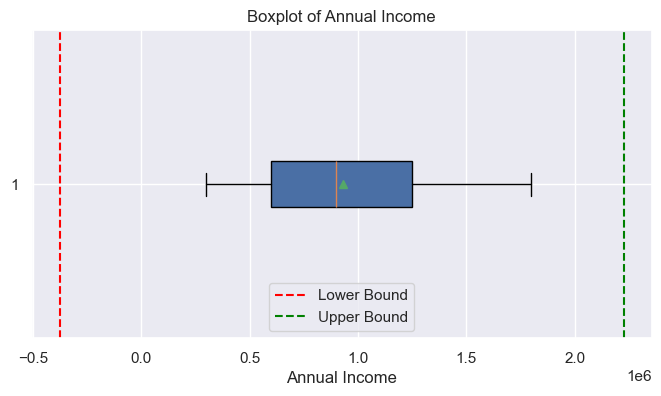

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
box = ax.boxplot(
    data_train["Annual Income"], vert=False, patch_artist=True, showmeans=True
)
for patch in box["boxes"]:
    patch.set(facecolor=c_blue)

plt.title(f"Boxplot of Annual Income")
plt.xlabel("Annual Income")
plt.axvline(lower_bound, color="red", linestyle="--", label="Lower Bound")
plt.axvline(upper_bound, color="green", linestyle="--", label="Upper Bound")
plt.legend()
plt.show()

The distribution does not present any outliers.

# 4. Exploratory Data Analysis (EDA)

## 4.1. Univariate Analysis

I will start by exploring each feature on its own. Visually analyzing the distributions looking for patterns and insights.

In [16]:
data = data_train.copy()  # Copy just for charting purposes
data["Age"] = data["Age"].astype(
    pd.CategoricalDtype(categories=sorted(data["Age"].unique()), ordered=True)
)
data['Family Members'] = data['Family Members'].astype(
    pd.CategoricalDtype(categories=sorted(data['Family Members'].unique()), ordered=True)
)
data["Chronic Diseases"] = data["Chronic Diseases"].replace({0: "No", 1: "Yes"})
data["Travel Insurance"] = data["Travel Insurance"].replace({0: "No", 1: "Yes"})

In [17]:
num_cols = ["Annual Income"]
cat_cols = [col for col in data.columns if col != "Annual Income"]

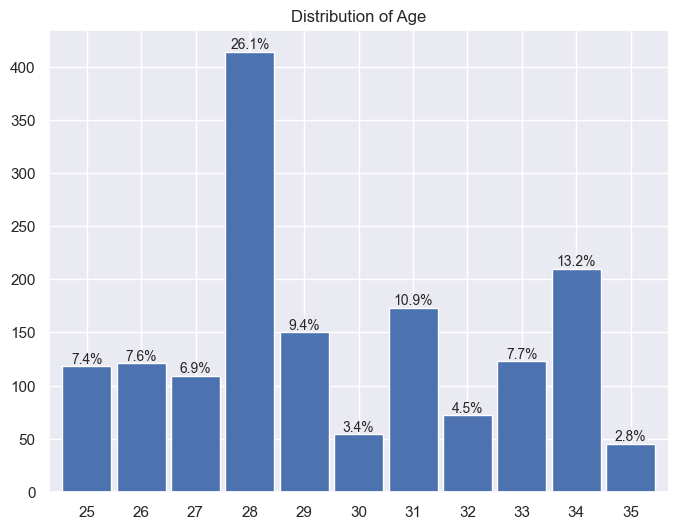

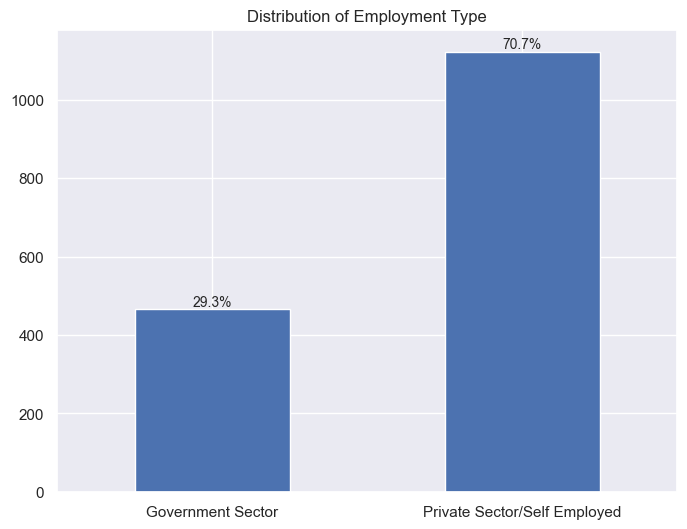

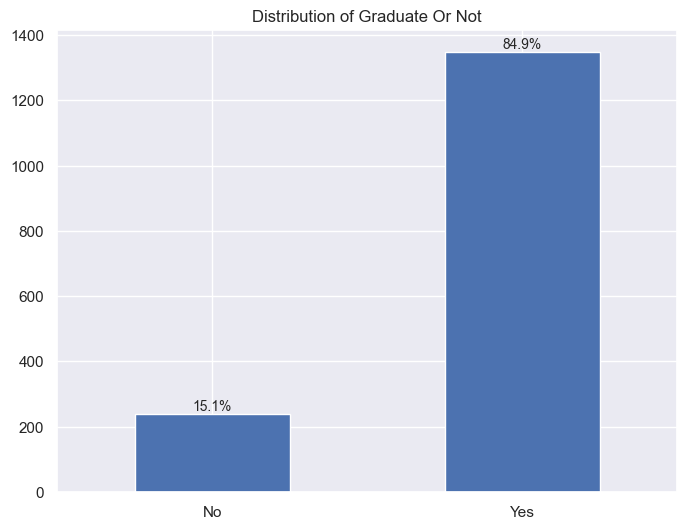

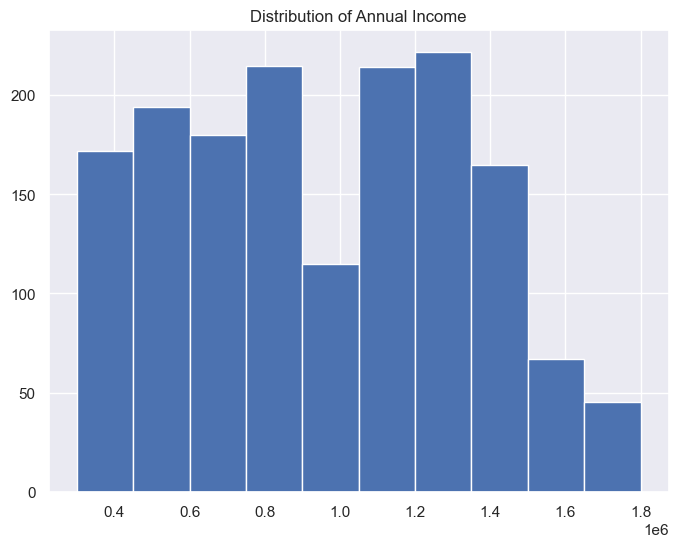

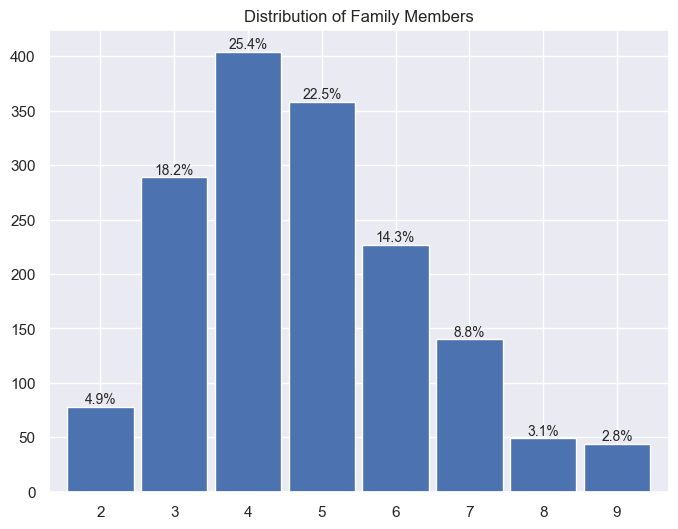

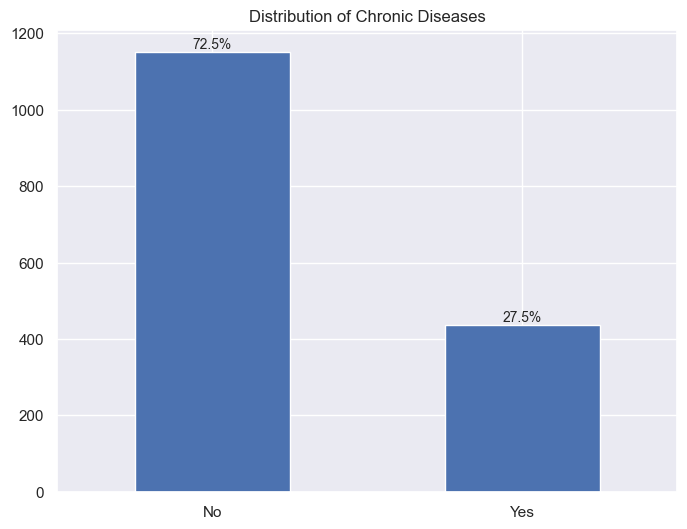

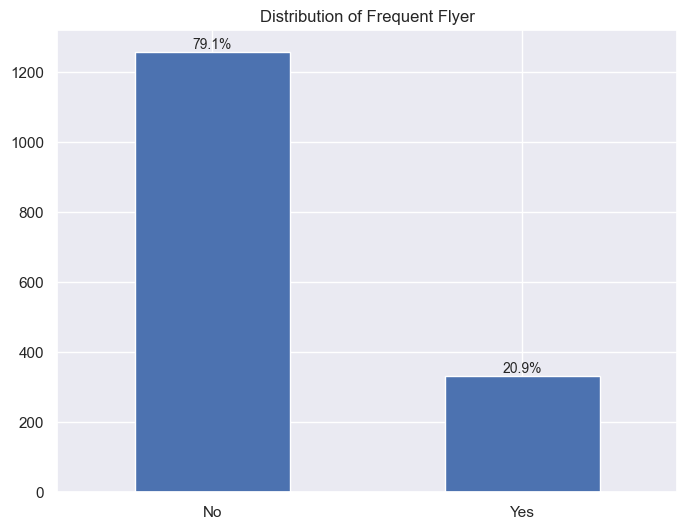

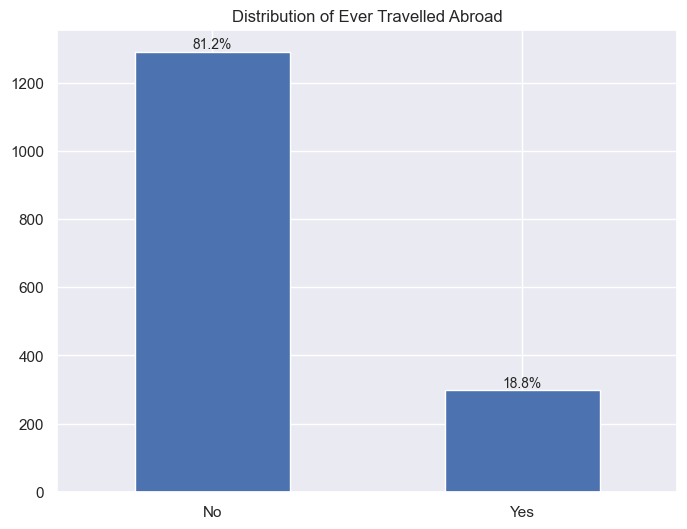

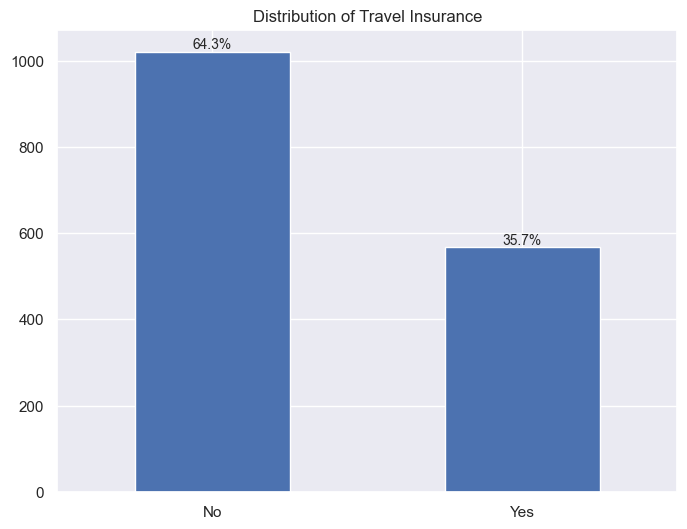

In [18]:
for column in data:
    plt.figure(figsize=(8, 6))
    plt.title(f"Distribution of {column}")
    if column in num_cols:
        data[column].plot(kind="hist")
        plt.ylabel("")
    elif column in cat_cols:
        value_counts = data[column].value_counts().sort_index()
        value_counts_p = (
            data[column].value_counts(normalize=True).sort_index() * 100
        )  # Get percentage values
        if column in ("Age", "Family Members"):
            ax = value_counts.sort_index().plot(kind="bar", width=0.9)
        else:
            ax = value_counts.sort_index().plot(kind="bar")

        # Add percentages on top of each bar
        for idx, (perc, val) in enumerate(zip(value_counts_p, value_counts)):
            plt.text(
                idx, val + 0.1, f"{perc:.1f}%", ha="center", va="bottom", fontsize=10
            )

        plt.xticks(rotation=0)
    plt.xlabel("")

**Comments:**

* It is strange that 26% of the customers are 28 years old. As previously stated, this features ranges from 25 to 35 years old, so it would be expected to see each age holding around 9% to 10% of the data. It would be worth checking with the team that gathered the data and the rest of the customer data base to check if this is actually representative from the whole population or it was somehow biased.
* Another strange fact is that the `Annual Income` has an inverted spike at the middle of the distribution. From this kind of variable it would be expected to see a distribution resembling more like a bell, with longer tails on the right side identifying outliers that earn much more than the rest.
* `Family Members` does show this bell-shaped distribution, with majority of families having between 3 and 5 members, and slowly decreasing up to 9 members.
* Another thing worth mentioning is the amount of people with `Chronic Diseases`, almost 30%.
* Only 18.8% of the customers have ever travelled abroad.
* 35.7% of the customers purchased the insurance service in the past.


### 4.1.1. Confidence Interval for the proportion of customers that pay the insurance cover

From the previous chart, it could be inferred that the proportion of customers that purchase the insurance is 35.7%, but the actual proportion may vary a little. Let's define here the interval where the true parameter may actually lie, with a confidence level of 95%.

I'll calculate them both analytically and empirically:

In [19]:
p_travel_insurance = np.mean(data_train["Travel Insurance"])
n = data_train.shape[0]
se = np.sqrt(p_travel_insurance * (1 - p_travel_insurance) / n)

z_mult = scipy.stats.norm.ppf(0.975)
lb = p_travel_insurance - z_mult * se
ub = p_travel_insurance + z_mult * se
print(
    f"95% CI for the proportion of people who bought travel insurance: [{lb:.4f}, {ub:.4f}]"
)

95% CI for the proportion of people who bought travel insurance: [0.3339, 0.3810]


Now using bootstrapping. I'll define a function so I can reuse it for different iterations and sample sizes.

In [20]:
def bootstrap_ci(
    df: pd.DataFrame,
    measure: str,
    label: str = "Travel Insurance Purchase",
    n_iterations: int = 10000,
    sample_size: int = 500,
    confidence_level: float = 0.95,
) -> None:
    """
    Calculating confidence interval using bootstrapping for the mean, and plotting the KDE with percentile lines.
    """

    sample_means = []

    for _ in range(n_iterations):
        sample = np.random.choice(df[measure], size=sample_size, replace=True)
        sample_means.append(np.mean(sample))

    # Calculate percentiles
    lb_1 = np.percentile(sample_means, (1 - confidence_level) / 2 * 100)
    ub_1 = np.percentile(sample_means, (1 + confidence_level) / 2 * 100)

    print(f"95% CI for {measure} in the {label} group: ({lb_1:.4f}, {ub_1:.4f})")

    # Plot KDE with percentile lines
    plt.figure(figsize=(10, 6))
    sns.kdeplot(sample_means, label=label, color=c_blue)

    # Add vertical lines for confidence intervals
    plt.axvline(lb_1, color=c_red, linestyle="--")
    plt.axvline(ub_1, color=c_red, linestyle="--")

    plt.xlabel(f"Sample Mean of {measure}")
    plt.ylabel("Density")
    plt.title(f"Bootstrap Sample Mean Distribution for {measure}")
    plt.legend()
    plt.show()

    return

95% CI for Travel Insurance in the Travel Insurance Purchase group: (0.3160, 0.4000)


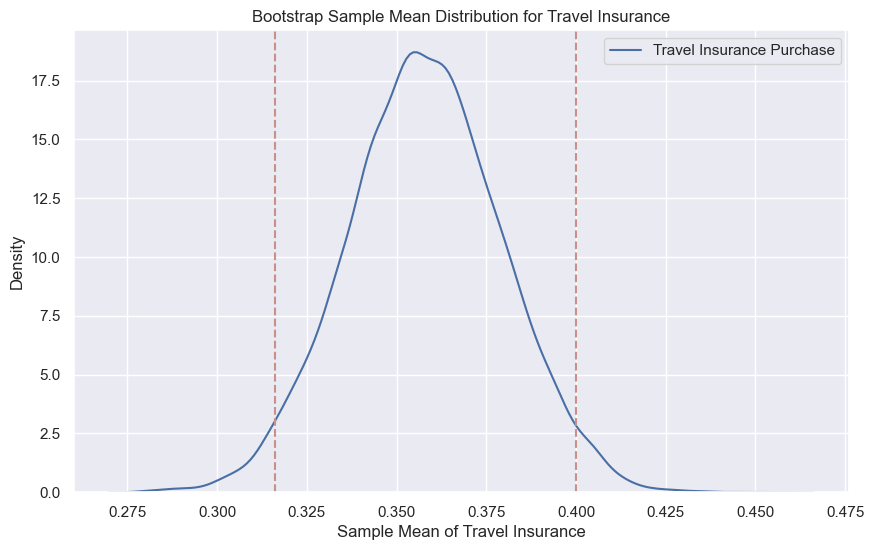

In [21]:
bootstrap_ci(data_train, "Travel Insurance")

**Confidence Interval Summary Table**

| **Method**             | **Confidence Level** | **Lower Bound** | **Upper Bound** | **Comments**                              |
|------------------------|----------------------|-----------------|-----------------|-----------------------------------------|
| **Analytical Approach** | 95%                  | 0.3339         | 0.3810         | Calculated using the standard error formula. |
| **Empirical Approach (Bootstrapping)** | 95%                  | 0.3160         | 0.4000         | Used 10,000 iterations and a sample size of 500 to achieve close results. |

---

 📌 **Key Insights:**
- The **analytical** approach provides a confidence interval based on the standard error derived from the **Central Limit Theorem (CLT)**. 
- The **empirical (bootstrapping)** method was used with **10,000 iterations** and a **sample size of 500** to approximate the CI non-parametrically.
- Despite the difference in methodology, both approaches resulted in **similar confidence intervals**, suggesting reliable results.


## 4.2. Multivariate Analysis

Let's find out the interactions between the features within each other.

* I will plot the correlation between all variables using the **Phik** correlation matrix.
* Then I will inspect the correlation between the target variable and the rest of them:
    * For the correlation with categorical variables I'll use a countplot with hue.
    * For the correlation with numerical I'll use a boxplot with hue.


### 4.2.1. Correlation between variables
**Phik** correlation measures associative relationships based on the chi-squared test and it is very handy since it works with **categorical**, **numerical** or **mixed** data types. Its key **strengh** is that it captures **non-linear** relationships and complex patterns often missed by other correlations, such as Spearman or Pearson correlations.

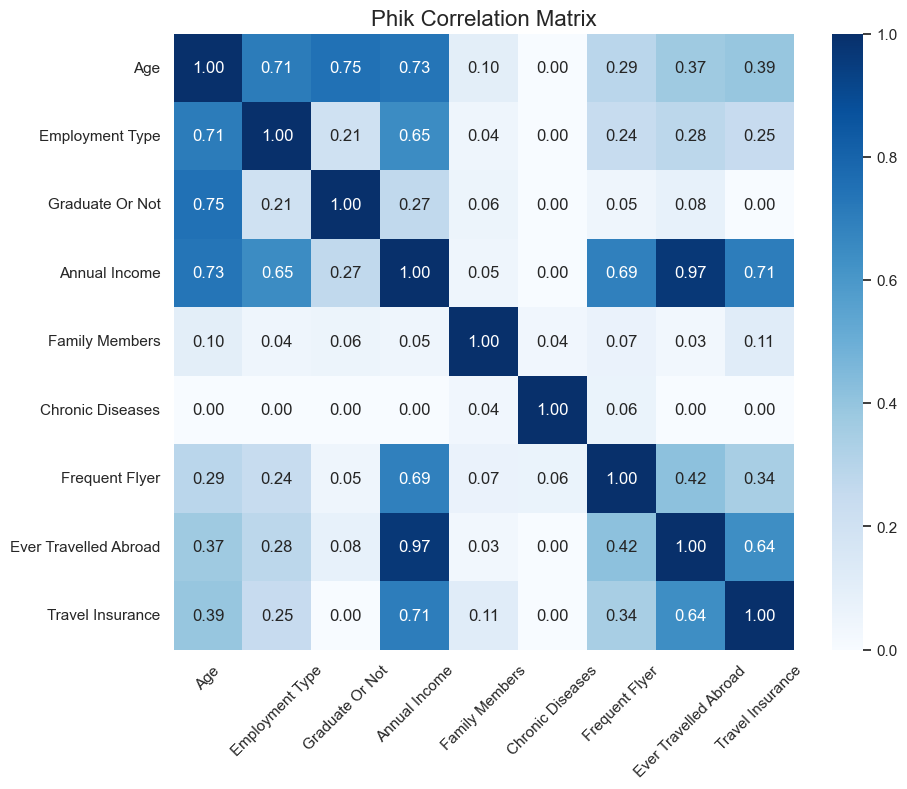

In [22]:
phik_corr = data.phik_matrix(interval_cols=['Age', 'Annual Income', 'Family Members'])
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, cmap='Blues', fmt=".2f")
plt.title("Phik Correlation Matrix", fontsize=16)
plt.xticks(rotation=45)
plt.show();

**Conclusions:**

* `Age` presents high correlation with `GraduateOrNot` (0.75), with `AnnualIncome` (0.73) and with `Employment Type` (0.71) indicating that older individuals might have higher income levels and that, in this sample, the age plays also an important role defining if a customer has a graduate or not and its type of employment.
* There's a extremely high correlation between `AnnualIncome` and `EverTravelledAbroad` (0.97), suggesting that individuals with higher annual income are highly likely to have traveled abroad. This may indicate potential multicollinearity between these features. `AnnualIncome` also shows a high correlation with the `FrequentFlyer` feature (0.69), which may be related with the previous correlation, as `FrequentFlyer` and `EverTravelledAbroad` show also a small correlation (0.42). `AnnualIncome` shows a mid-high correlation with `Employment Type` as well. 
* The target variable `TravelInsurance` is correlated with `AnnualIncome` and `EverTravelledAbroad` (0.71 and 0.64 respectively).

I'll plot this correlations visually to see if we can visually appreciate this relations. 
* For numerical vs. categorical features I'll define a function that will use a box plot to show the distribution of values of the numerical feature across categories. 
* For categorical vs. categorical I'll define another function that will show a barplot with the counts on each category and another barplot with the relative count (percentage).


### 4.2.2. Numerical vs Categorical features

I will start by exploring the correlations between numerical and categorical features.

In [23]:
def num_vs_cat_feature(
    data: pd.DataFrame, 
    num_feature: str, 
    cat_feature: str
) -> None:
    """
    Plot boxplots for a numerical feature against a categorical feature.
    
    Parameters:
    - data (pd.DataFrame): The dataset containing the features.
    - num_feature (str): The name of the numerical feature.
    - cat_feature (str): The name of the categorical feature.
    
    Returns:
    - None: Displays a boxplot but does not return any value.
    """
    # Identify unique values in the categorical feature
    unique_values = data[cat_feature].unique()

    # Check if the unique values are specifically "Yes" and "No"
    if set(unique_values) == {"Yes", "No"} or set(unique_values) == {"No", "Yes"}:
        # Define custom colors and order if it's a Yes/No scenario
        c_palette = {"No": c_red, "Yes": c_blue}
        category_order = ["No", "Yes"]
    else:
        # Otherwise, use a default Seaborn palette and inferred order
        c_palette = custom_palette
        category_order = sorted(unique_values)


    plt.figure(figsize=(8, 6))
    sns.boxplot(
        x=cat_feature, 
        y=num_feature, 
        data=data, 
        hue=cat_feature, 
        palette=c_palette,
        order=category_order,
        showmeans=True
    )
    plt.title(f"Distribution of {num_feature} by {cat_feature}", fontsize=16)
    plt.show()

Let's visualize the possible correlation between `Annual Income` and `Ever Travelled Abroad`:

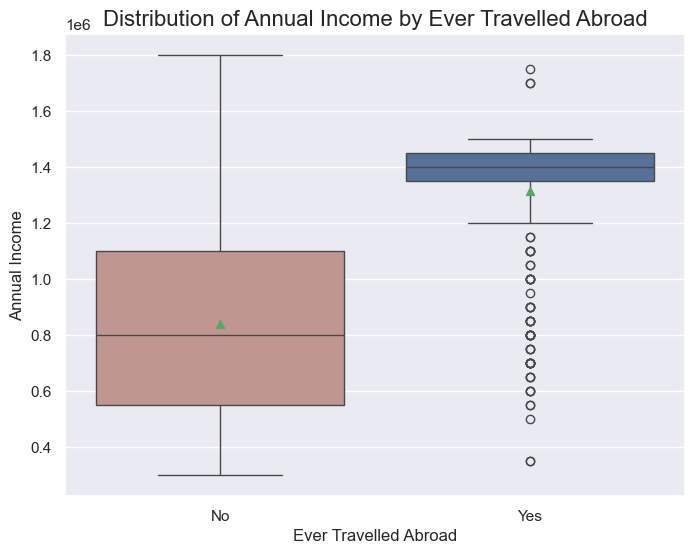

In [24]:
num_vs_cat_feature(data, "Annual Income", "Ever Travelled Abroad")

As we can see, there's a clear difference between the people who ever travelled abroad and the ones who didn't. Where the ones who did not travelled abroad usually have lower income.


I'll check now the correlation between `Age` and `Annual Income`. I'm treating `Age` as a categorical ordered variable, as the range only expands for 11 years, to see if there are differences across ages:

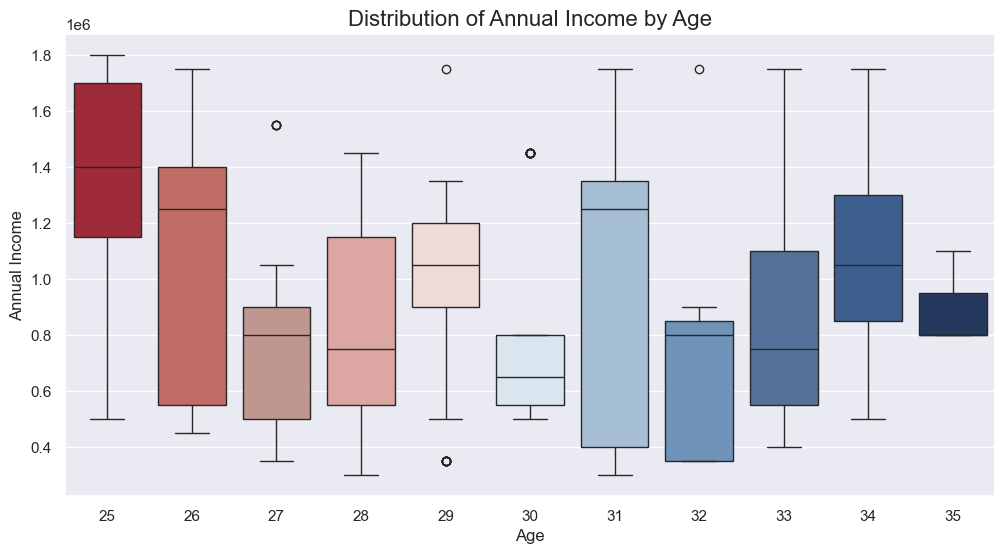

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Annual Income', data=data, hue='Age', 
            palette=["#b21729","#d05f57","#c89089","#e69f98","#f3d7d3",
                     "#d7e7f2","#9ebfdb","#6493c5","#4a6fa5","#2f5d9e",
                     "#1c3566"],
            legend=False
            )
plt.title(f"Distribution of Annual Income by Age", fontsize=16)
plt.show()

The plot shows a wide variance in annual income across different age groups, making it challenging to draw clear conclusions. However, it could suggest that customers aged 25 years tend to have the highest incomes on average, while those aged 30 years appear to earn comparatively less than other groups. This distribution could indicate a risk of overfitting if a model were to rely heavily on this pattern, as the data seems to reflect the specifics of this sample rather than a generalizable trend. To further investigate the relationship between age and annual income, we can check for monotonic correlation using a Pearson correlation matrix and visualize the trend with a scatter plot.:

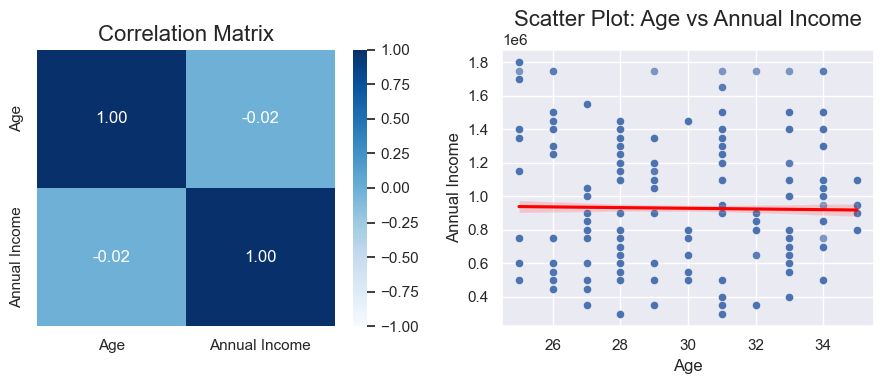

In [26]:
age_income_df = data[['Age', 'Annual Income']]
corr_matrix = age_income_df.corr()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='Blues', 
    vmin=-1, vmax=1, center=0, 
    ax=axes[0]
)
axes[0].set_title("Correlation Matrix", fontsize=16)

sns.scatterplot(
    data=age_income_df, 
    x='Age', 
    y='Annual Income',
    alpha=0.7,  
    ax=axes[1]
)
sns.regplot(
    data=age_income_df, 
    x='Age', 
    y='Annual Income',
    scatter=False, 
    color='red',
    ax=axes[1]  # Adding a regression line
)
axes[1].set_title("Scatter Plot: Age vs Annual Income", fontsize=16)


plt.tight_layout()
plt.show();

As we can interpret from both plots, the Pearson correlation matrix does not recognize any correlation between the features. This may indicate that the Phik correlation may be overfitting the data, since this could happen when working with limited ranges. Another option would be to convert this feature into a category, grouping all customers from 25 to 30 years into one group and another one from 31 to 35. This way, the correlation would not learn from the specifics of each age and the correlation would get smoother. 

Following this approach, I will define a new feature `Young Adult` that would take two possible values:
* `1` if the customer is at most 30 years old.
* `0` if the customer is older than 30 years.

In [27]:
data_train['Young Adult'] = data_train['Age'].apply(lambda x: 1 if x <= 30 else 0)
data['Young Adult'] = data['Age'].apply(lambda x: 'Yes' if x <= 30 else 'No')

After doing the transformation, I can remove the `Age` feature.

In [28]:
data.drop(columns='Age', inplace=True)
data_train.drop(columns='Age', inplace=True)

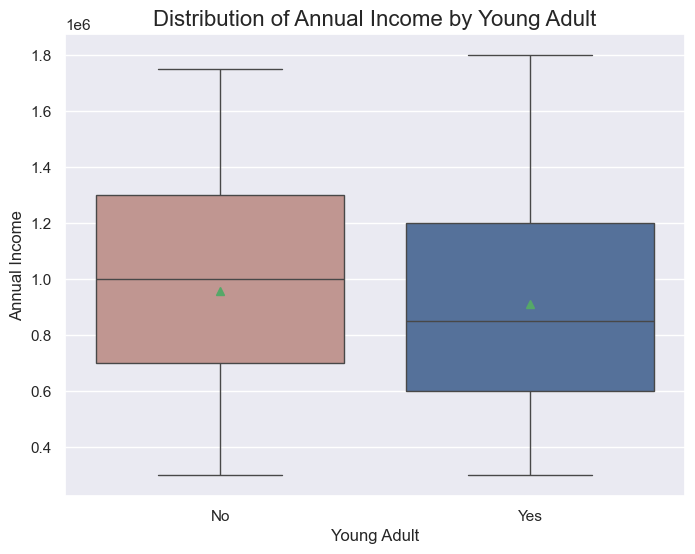

In [29]:
num_vs_cat_feature(data, "Annual Income", "Young Adult")

After transforming the `Age` variable into a categorical group (Young Adult defined as ages 25 to 30 and others as ages 31 to 35), the distribution of Annual Income shows some notable patterns:

* The young adults' income distribution appears slightly lower than that of the older group, but both groups have similar means.
* The young adult group seems to have a wider spread, suggesting a greater presence of high-income outliers compared to the older group.
* The downward shift in the young adults' income distribution may be influenced by the inclusion of 30-year-old customers, who appear to earn less than other ages in the dataset (as observed in the second plot).
* Conversely, the inclusion of 25-year-old customers (who seem to have the highest income) could be balancing this downward effect, potentially reducing the gap between the two groups.

Let's check the Phik correlations now:

In [30]:
phik_corr2 = data.phik_matrix(interval_cols=['Annual Income', 'Family Members'])
phik_corr2.loc['Young Adult', :]

Employment Type          0.358113
Graduate Or Not          0.097372
Annual Income            0.404447
Family Members           0.000000
Chronic Diseases         0.000000
Frequent Flyer           0.000000
Ever Travelled Abroad    0.105076
Travel Insurance         0.158519
Young Adult              1.000000
Name: Young Adult, dtype: float64

The correlations have significantly dropped.

Let's visualize now the distribution of annual income on each category of the `Graduate Or Not` and `Employment Type` features:

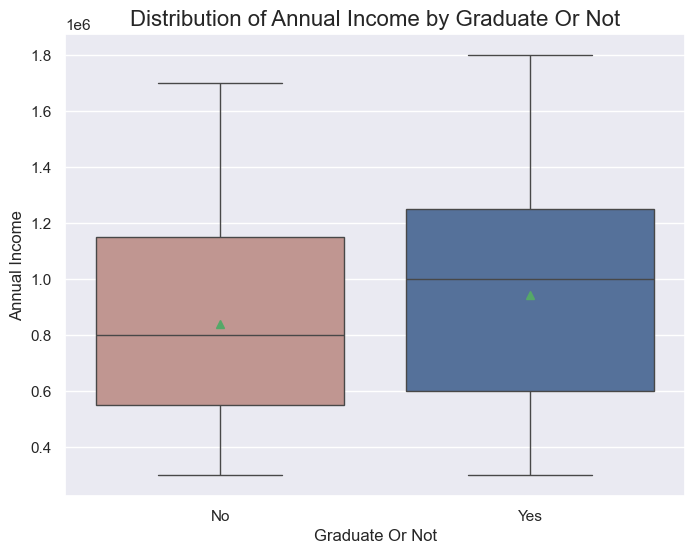

In [31]:
num_vs_cat_feature(data_train, "Annual Income", "Graduate Or Not")

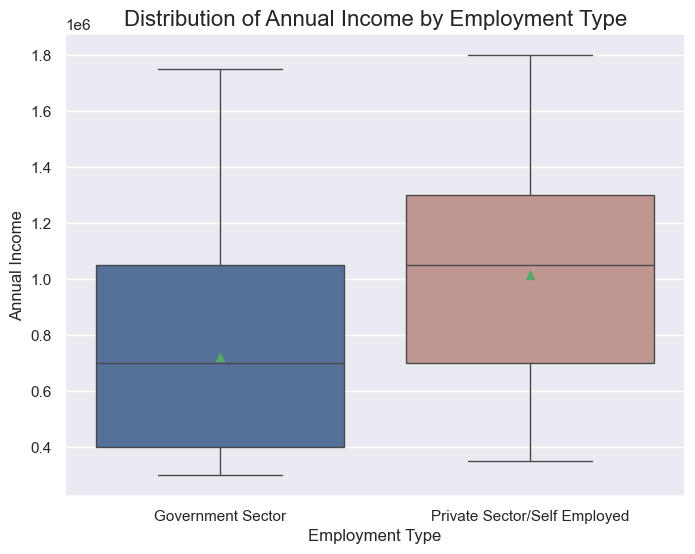

In [32]:
num_vs_cat_feature(data, "Annual Income", "Employment Type")

Looking at these two charts, it seems that people holding a college graduate earn on average a bit more than the ones not holding one. Also, government employees tend to earn less than the ones working for the private sector or are self-employed.

Let's see now the distribution of the `Annual Income` in contrast to the target variable:

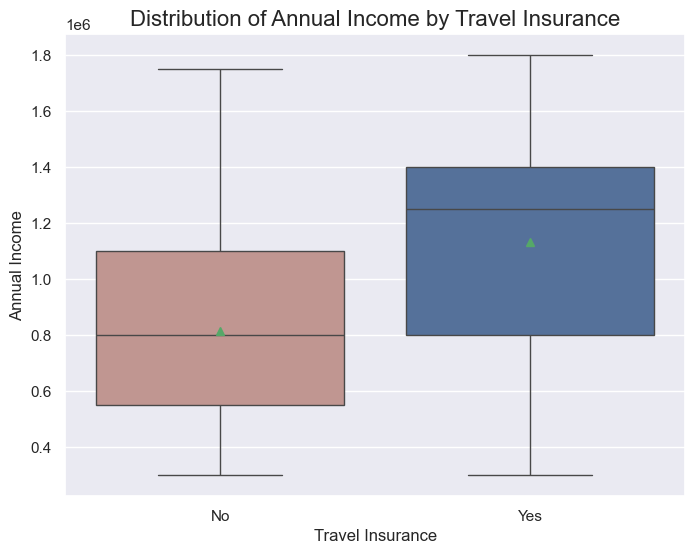

In [33]:
num_vs_cat_feature(data, "Annual Income", "Travel Insurance")

There's a clear difference here. Customers who purchase the insurance earn on average more that the ones who don't.

### 4.2.3. Categorical vs. Categorical features

Let's define now a function to inspect the correlation between categorical variables, for that the function will display two plots per feature:
* one displaying the absolute count of observations within each category and 
* another showing the normalized percentage per category for a clearer comparison across groups.

In [34]:
def cat_vs_cat_plot(
    data: pd.DataFrame, 
    primary_cat: str, 
    secondary_cat: str
) -> None:
    """
    Plots two countplots side by side for the relationship between two categorical features:
    - Left plot: Absolute count
    - Right plot: Normalized percentage per category.

    Parameters:
    - data (pd.DataFrame): The dataset containing the features.
    - primary_cat (str): The primary categorical feature to plot.
    - secondary_cat (str): The secondary categorical feature used as the hue.

    Returns:
    - None: Displays the plots but does not return any value.
    """
    
    if isinstance(data[primary_cat].dtype, pd.CategoricalDtype) and data[primary_cat].dtype.ordered:
        ordered_categories = data[primary_cat].cat.categories.tolist()
    else:
        # If not ordered, use sorted unique values
        ordered_categories = sorted(data[primary_cat].unique())

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    # 📊 Left Plot: Absolute Countplot
    chart_count = sns.countplot(
        data=data,
        x=primary_cat,
        hue=secondary_cat,
        palette=custom_palette,
        order=ordered_categories,
        ax=axes[0]
    )

    # Add total counts on top of each bar
    for p in chart_count.patches:
        if p.get_height() > 0:  
            chart_count.annotate(
                f"{int(p.get_height())}",
                (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                ha="center",
                fontsize=10
            )

    # Title and formatting for absolute counts
    axes[0].set_title(f"Absolute Count by {primary_cat} and {secondary_cat}", fontsize=14)
    axes[0].set_xlabel(primary_cat)
    axes[0].set_ylabel("")


    # 📈 Right Plot: Normalized Percentages
    ct1 = pd.crosstab(data[primary_cat], data[secondary_cat], normalize="index")
    ct1_long = ct1.reset_index().melt(id_vars=primary_cat, var_name=secondary_cat, value_name="Percentage")
    ct1_long["Percentage"] *= 100  # Convert to percentages

    # Barplot for normalized percentages
    chart_percent = sns.barplot(
        data=ct1_long,
        x=primary_cat,
        y="Percentage",
        hue=secondary_cat,
        palette=custom_palette,
        order=ordered_categories,
        ax=axes[1]
    )

    # Adding percentages on top of each bar
    for p in chart_percent.patches:
        if p.get_height() > 0:
            chart_percent.annotate(
                f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height() + 0.5),
                ha="center",
                fontsize=10
            )

    # Title and formatting for percentages
    axes[1].set_title(f"Normalized Percentage by {primary_cat} and {secondary_cat}", fontsize=14)
    axes[1].set_xlabel(primary_cat)
    axes[1].set_ylabel("")

    # Adjust the spacing between plots
    plt.tight_layout()
    plt.show()

Since the Phik correlation matrix did not show any important correlation between categorical features, I'll only plot the counts of each categorical feature in relation with the target variable.

In [35]:
cols_to_remove_fom_categories = ['Travel Insurance', 'Annual Income']
cat_cols = [col for col in data.columns if col not in cols_to_remove_fom_categories]

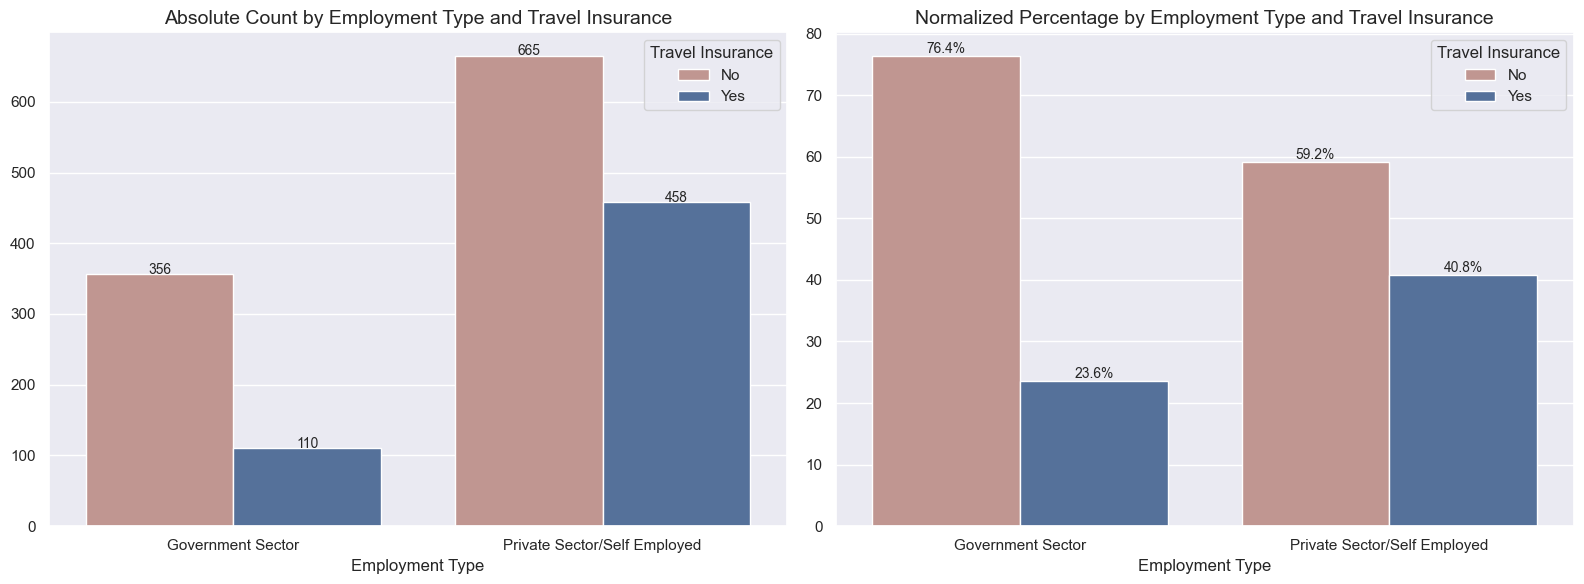

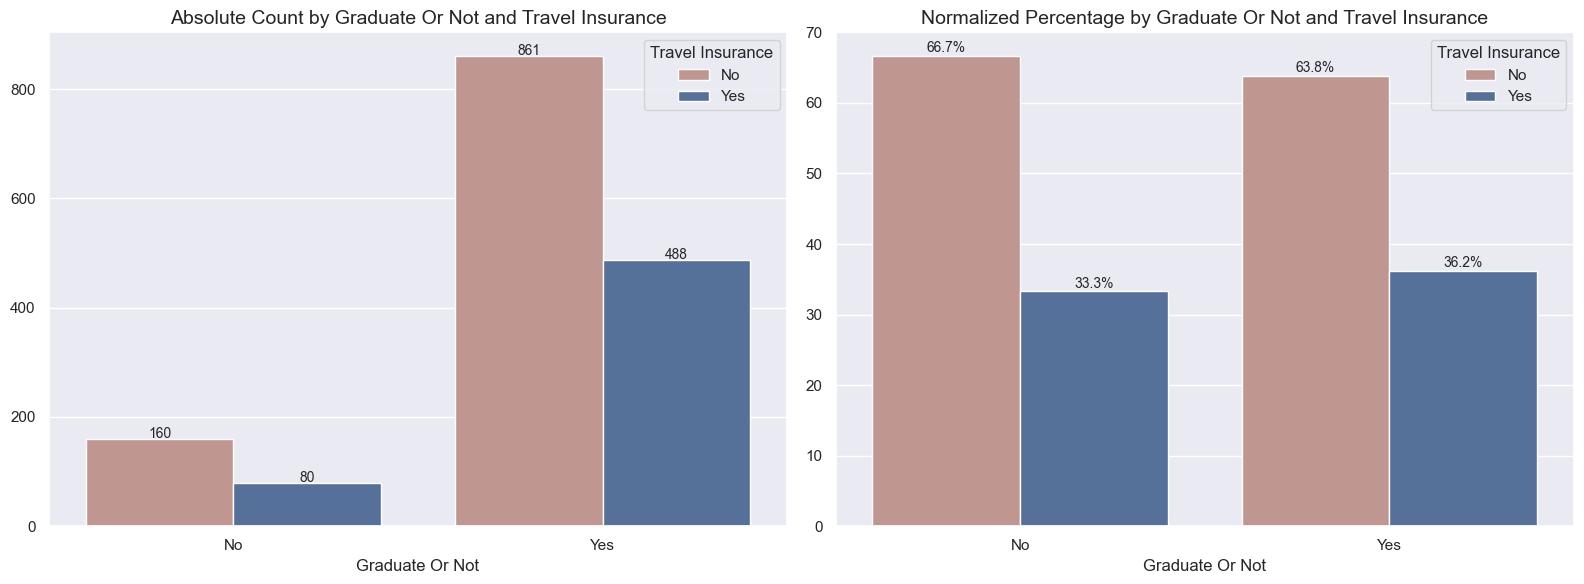

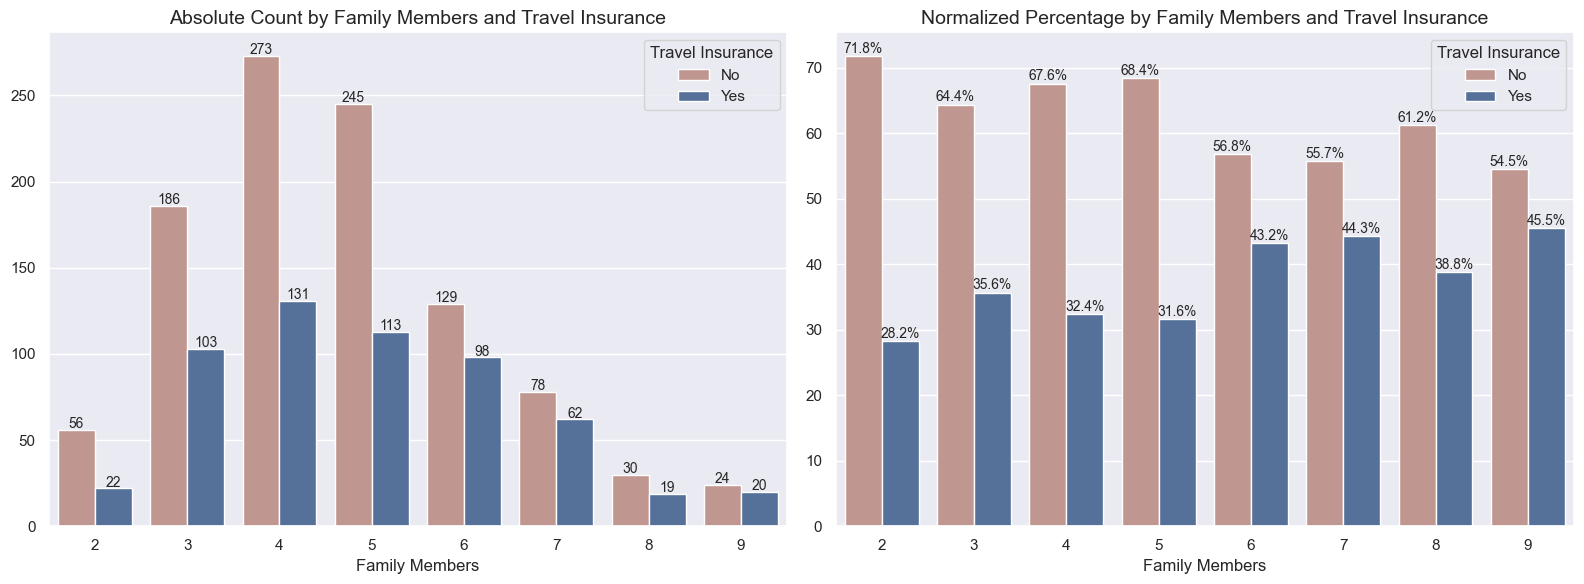

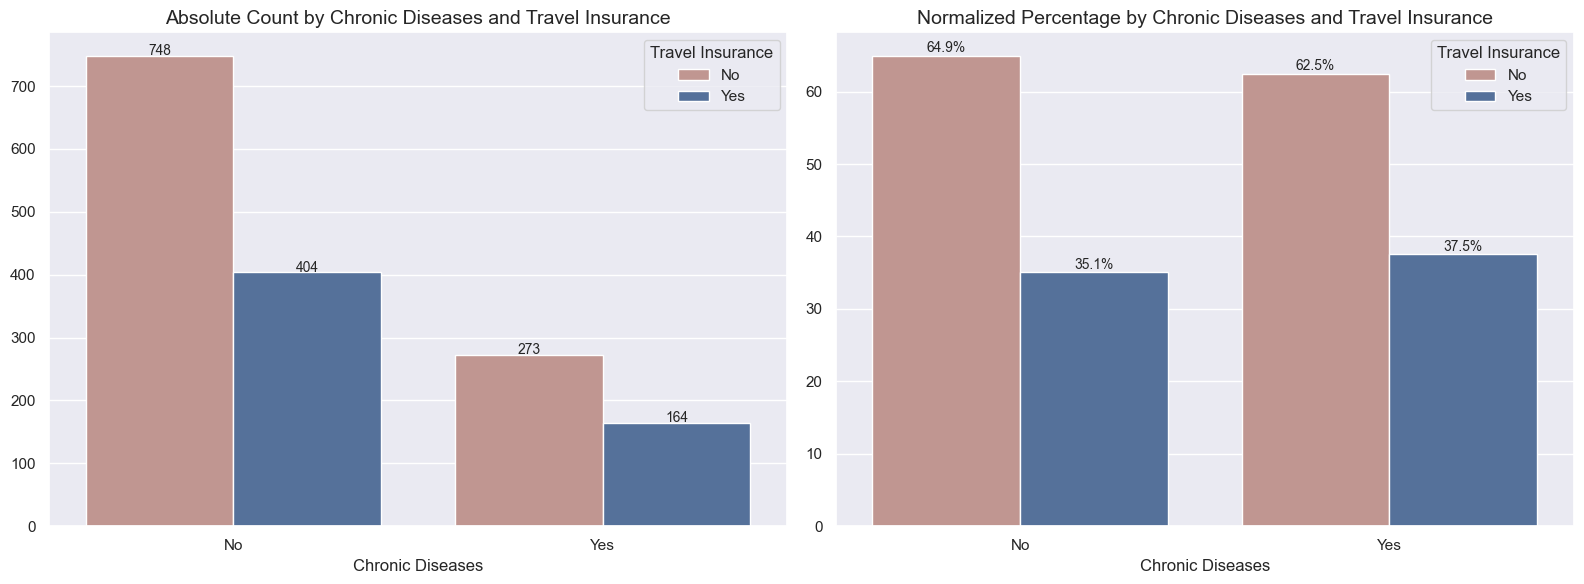

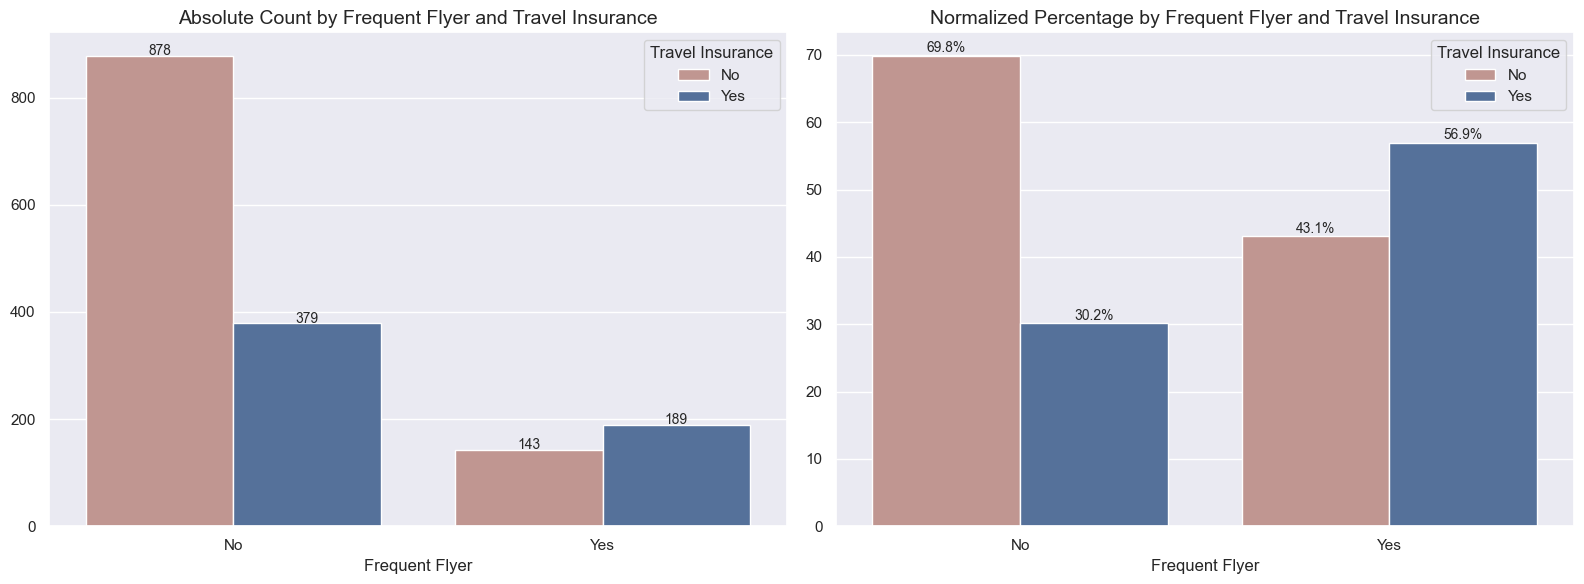

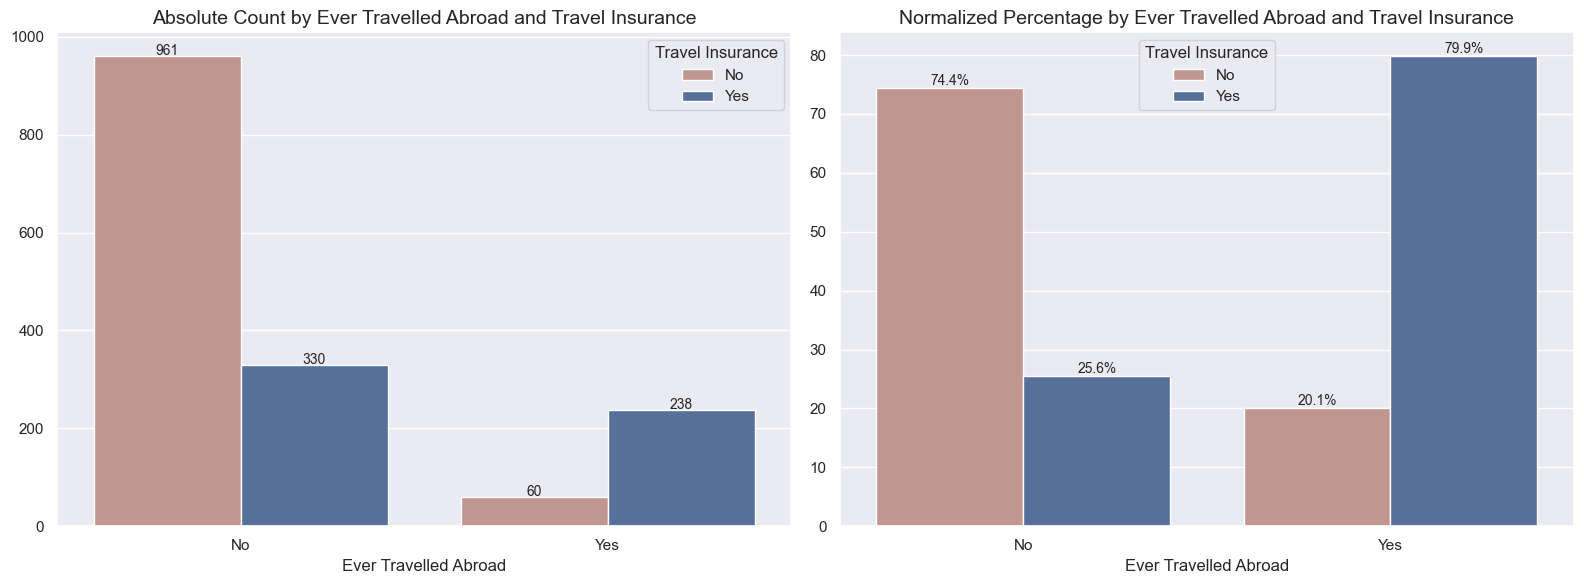

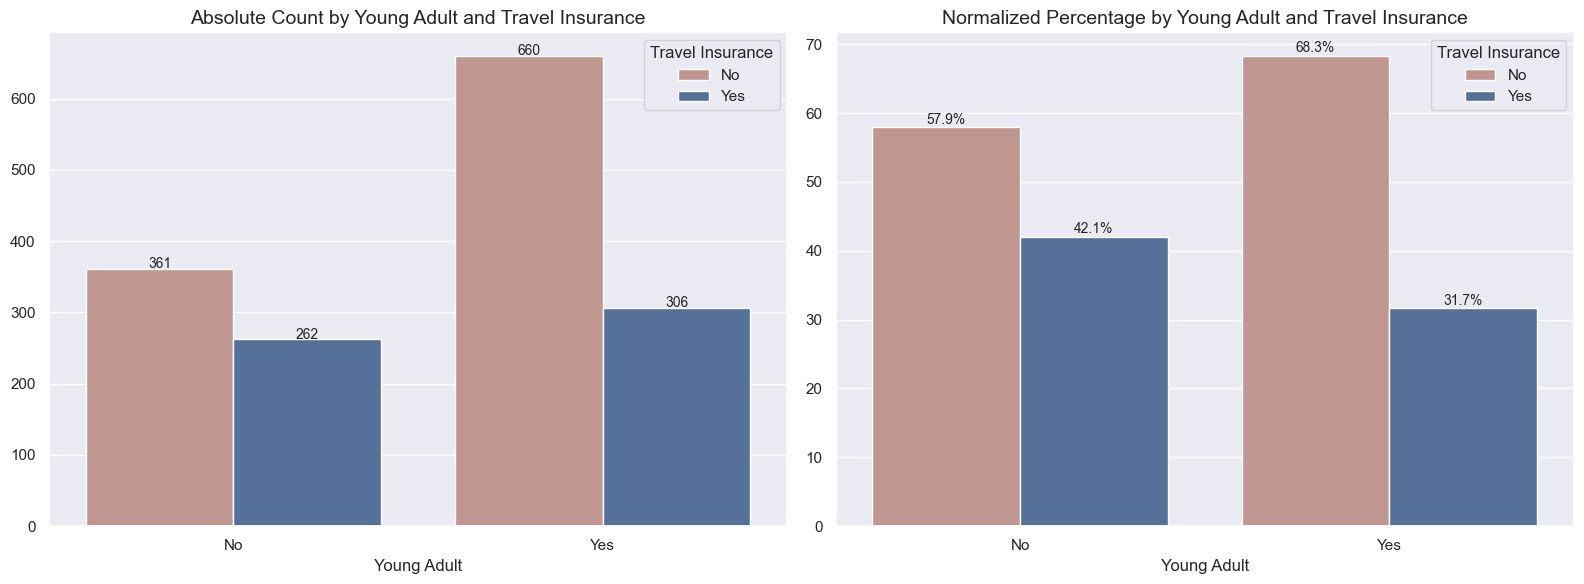

In [36]:
for cat in cat_cols:
    cat_vs_cat_plot(data, cat, "Travel Insurance")

I will do the transformation I talked about the family sizes:

In [37]:
data['Big Family'] = data['Family Members'].apply(lambda x: 'Yes' if x >= 6 else 'No')
data_train['Big Family'] = data_train['Family Members'].apply(lambda x: 1 if x >= 6 else 0)

In [38]:
data.drop(columns='Family Members', inplace=True)
data_train.drop(columns='Family Members', inplace=True)

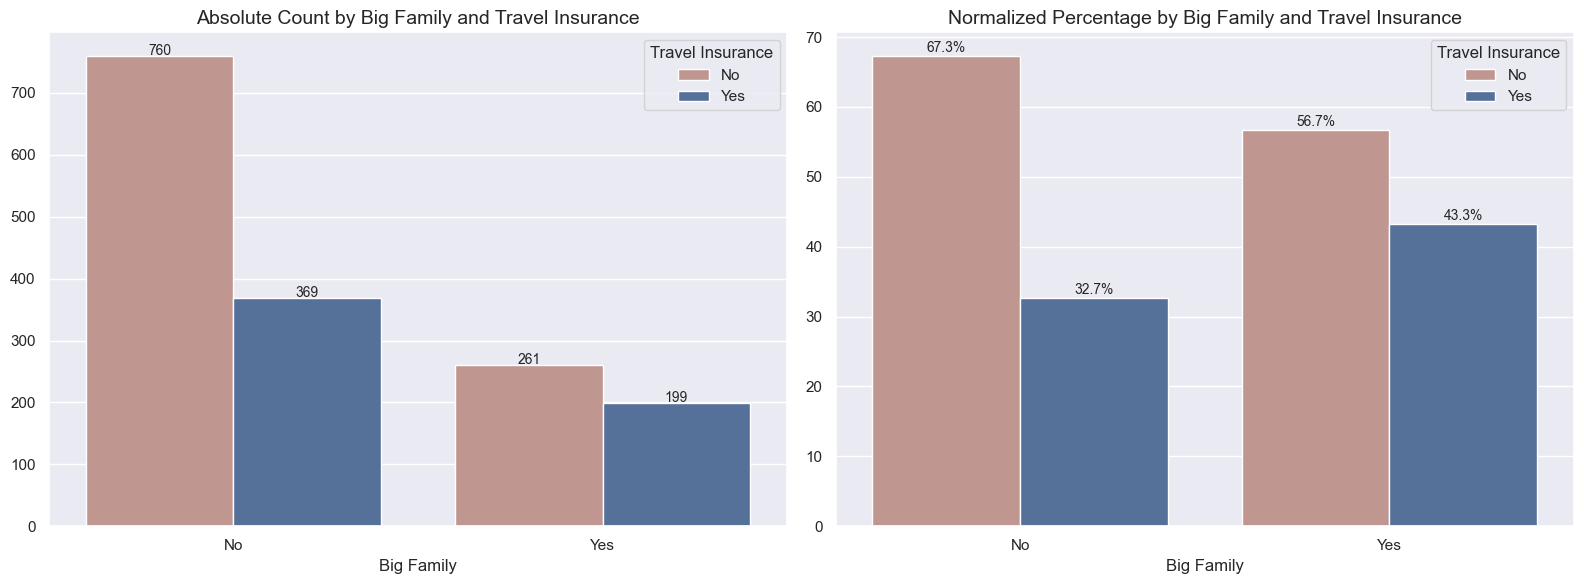

In [39]:
cat_vs_cat_plot(data, "Big Family", "Travel Insurance")

We can extract the following insights from the charts:
* `Employment Type`: The proportion of employees working in the private sector or being self-employed who purchase the insurance is higher than that of public sector employees. This indicates that employment type may influence the decision to buy insurance.
* `Graduate Or Not` and `Chronic Diseases`: As shown in the charts, neither educational background nor the presence of chronic diseases appears to significantly impact the likelihood of purchasing travel insurance. The proportions between the groups are very similar, suggesting minimal influence on purchasing behavior.
* `Family Members`: The data suggests a potential trend where families with 6 or more members are more likely to purchase insurance. The proportion of insurance purchases for families with 5 or fewer members is slightly above 30%, whereas for families with 6 or more, the purchase rate exceeds 40%. This pattern suggests the possibility of creating a binary grouping: families with up to 5 members and families with 6 or more members to better capture this effect.
* `Frequent Flyer` and `Ever Travelled Abroad`: Both being a frequent flyer and having traveled abroad appear to play a significant role in the decision to purchase insurance, with higher proportions observed among those who have engaged in frequent travel.
* `Young Adult`: The Young Adult feature (grouping ages 25 to 30) suggests that the older group (ages 31 to 35) tends to purchase insurance more frequently. This could indicate that age plays a role in influencing insurance decisions.

Based on these and the previous charts (numerical vs categorical) I'm defining the following hypothesis:
* **Hypothesis 1:** Is there any significant difference in the mean annual income of young adults and the older ones?

I mentioned that holding a college graduate or having a chronic disease does not increase the likelihood of purchasing the travel insurance since the difference in the proportions in these groups is small, but let's actually verify that.
* **Hypothesis 2:** Are customers who hold a college graduate more likely to purchase the insurance?
* **Hypothesis 3:** Does having a chronic diease increases the chances of paying for the travel insurance?

# 5. Hypotheses testing

Now I'll move to test the formulated hypotheses from the previous section.

The first hypothesis test for a difference in means, while the other two test for a difference in proportions. 

**Details:**
* I'll be testing all of them for a **significance level** of ($\alpha$) of 5%.
* The **target population** of the tests are customers from India, aged between 25 and 35 years old.

## 5.1. Hypothesis 1

I'll verify if there exists a statistically significant difference in the mean annual income of customers categorized as young adults and the rest:
* Young adults (group A)
* Older adults (group B)

The null hypothesis would be that the mean annual income of group A is the same of group B, since that is what I want to reject:
* $H_0: \mu_A = \mu_B$
* $H_1: \mu_A \neq \mu_B$

Where $\mu$ stands for the mean annual income in each group.

In [40]:
dx = data[["Young Adult", "Annual Income"]]
ct = dx.groupby("Young Adult").agg(["mean", "std", "size"])
ct.columns = ["Mean", "Std", "N"]
ct

,Mean,Std,N
Young Adult,,,
No,956260.032103,371634.059791,623
Yes,911956.521739,381725.564245,966


The standard deviation are close (within 2x of each other) so I'll use a pooled test.

In [41]:
group_no = data[data["Young Adult"] == "No"]["Annual Income"]
group_yes = data[data["Young Adult"] == "Yes"]["Annual Income"]

# Perform a two-sided t-test
t_stat, p_val = scipy.stats.ttest_ind(group_yes, group_no, equal_var=True)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

T-statistic: -2.2821
P-value: 0.0226


The result seems to be significant, as the p-value is lower than our alpha level (0.05).

## 5.2. Hypothesis 2

**Hypothesis 2:** Are customers who hold a college graduate more likely to purchase the insurance?

The null hypothesis (what I want to reject) would be that the proportion of customers that pay for the insurance and hold a college graduate is the same that the proportion of customers who pay for the insurance not holding a college graduate. 

* $H_0: p_A = p_B$
* $H_1: p_A \neq p_B$

Where $p_A$ is the proprotion of customers who have a college graduate and pay for the insurance and $p_B$ is the proportion of customers who do not have a college graduate and pay for the insurance.

I'm going to define a function to help me with the tests:

In [42]:
def proportions_ztest_by_group(
    data, target_col, group_col, group1, group2, alternative="larger"
):
    """
    Perform a z-test for proportions between two groups.

    Parameters:
    - data: pd.DataFrame
        The dataset containing the target and grouping columns.
    - target_col: str
        The target binary variable for success (e.g., 1 for success, 0 for failure).
    - group_col: str
        The column that defines the groups (e.g., 'Employment Type').
    - group1: str
        The first group to compare.
    - group2: str
        The second group to compare.
    - alternative: str
        The alternative hypothesis. One of 'two-sided', 'larger', or 'smaller'.
            larger would state that the proportion in group1 is larger than in group2 in the alternative hypothesis.

    Returns:
    - z_stat: float
        The z-statistic for the test.
    - p_value: float
        The p-value for the test.
    """
    # Calculate proportions and sample sizes for each group
    ct = data.groupby(group_col)[target_col].agg([lambda x: np.mean(x), "size"])
    ct.columns = ["Proportion", "N"]

    print(ct, "\n")

    # Get the success counts and sample sizes for the two groups
    prop1, n1 = ct.loc[group1, "Proportion"], ct.loc[group1, "N"]
    prop2, n2 = ct.loc[group2, "Proportion"], ct.loc[group2, "N"]

    successes = [prop1 * n1, prop2 * n2]  # Success counts
    nobs = [n1, n2]  # Sample sizes

    # Perform the z-test
    z_stat, p_value = sm.stats.proportions_ztest(
        successes, nobs, alternative=alternative
    )

    return z_stat, p_value

I'll call the function now:

In [43]:
z_stat, p_val = proportions_ztest_by_group(
    data=data_train,
    target_col="Travel Insurance",
    group_col="Graduate Or Not",
    group1="Yes",
    group2="No",
    alternative="two-sided",
)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

                 Proportion     N
Graduate Or Not                  
No                 0.333333   240
Yes                0.361749  1349 

Z-statistic: 0.8464
P-value: 0.3974


## 5.3. Hypothesis 3

**Hypothesis 3:** Does having a chronic diease increases the chances of paying for the travel insurance?

Again, the null hypotheses here would be that the proportion of people who have a chronic disease and purchased the insurance is equal to the proportion of customers who don't have a chronic disease and purchased the insurance.

* $H_0: p_A = p_B$
* $H_1: p_A \neq p_B$

Where $p_A$ is the proprotion of customers who have a chronic disease and pay for the insurance and $p_B$ is the proportion of customers who don't have a chronic disease and pay for the insurance.

In [44]:
cd_df = data_train[['Chronic Diseases', 'Travel Insurance']].copy()
cd_df['Chronic Diseases'] = cd_df['Chronic Diseases'].astype(object).replace({0: 'No', 1: 'Yes'})

In [45]:
z_stat, p_val = proportions_ztest_by_group(
    data=cd_df,
    target_col="Travel Insurance",
    group_col="Chronic Diseases",
    group1="Yes",
    group2="No",
    alternative="two-sided",
)

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val:.4f}")

                  Proportion     N
Chronic Diseases                  
No                  0.350694  1152
Yes                 0.375286   437 

Z-statistic: 0.9133
P-value: 0.3611


## 5.5.Summary Results

| **Null Hypotheses**                                                                                     | **Statistic**   | **P-value**        | 
|---------------------------------------------------------------------------------------------------------|-----------------|--------------------|
| **Hypothesis 1**: The mean annual income of young adults (25-30 years) is the same as the older adults (31-35) | T-statistic: -2.2821 | P-value: 0.0226 | 
| **Hypothesis 2:** The proportion of college graduates who pay for the travel insurance is the same as the proportion of non-college graduates | Z-statistic: 0.8464 | P-value: 0.3974 | 
| **Hypothesis 3:** The proportion of customers paying for the insurance is the same across people who have a chronic disease and those who do not | Z-statistic: 0.9133 | P-value: 0.3611 | 

---

**Conclusion:**

* The first hypothesis yielded statistically significant results with a small p-values (0.02 < 0.05), so we can reject the null hypothesis and conclude that young adults earn less than older adults. 
* The other two, on the other side did not show significant results, so we can't say that having a chronic disease or holding a college graduate have any impact on the likelihood of purchasing the insurance.


# 6. Modelling

Now I'll move to experiment with different models.

I first check the columns that need to be processed and split the data into the independent variables (X) and dependent variable (y).

In [46]:
X_train = data_train.drop(columns="Travel Insurance")
y_train = data_train["Travel Insurance"]

Let's revisit the head to see which columns need to be preprocessed.

In [47]:
data_train.head()

,Employment Type,Graduate Or Not,Annual Income,Chronic Diseases,Frequent Flyer,Ever Travelled Abroad,Travel Insurance,Young Adult,Big Family
1617,Private Sector/Self Employed,Yes,1150000,1,No,No,0,1,1
675,Private Sector/Self Employed,No,350000,0,No,No,0,1,0
127,Government Sector,Yes,750000,0,No,No,0,1,0
1334,Government Sector,Yes,750000,0,No,Yes,1,1,0
1425,Government Sector,Yes,600000,0,No,No,0,1,0


Define a preprocessor:

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["Annual Income"]),
        ("cat", OneHotEncoder(drop="first"), selector(dtype_include=object)),
    ],
    remainder="passthrough",
)

I'll define a framework to help in comparing the different models. I'll compare several models:
* Dummy model that will always predict that the customer will purchase the insurance.
* Logistic Regression.
* Support Vector Classifier.
* KNeighbors Classifier.
* Random Forest Classifier.
* Gaussian Naive Bayes.
* Hist Gradient Boosting Classifier.

I'll compare the **recall**, **ROC AUC**, **average precision (PR AUC)** and the **f1 score** for each of them as well as the time each models takes for fitting the data. The reason behind choosing the recall as the primary metric is that what I want to minimize is the likelihood of missing a customer who would pay for the insurance, since the cost of missing this customer would be much higher than the cost of offering the insurance to a non-potential buyer.

* **ROC AUC** evaluates the model's ability to distinguish between **positive and negative classes**.
    * It balances **True Positive Rate (Recall)** and **False Positive Rate (FPR)**
    * Good for balanced datasets where both classes are equally important
* **Precision-Recall AUC** focuses on the model's performance on predicting the **positive class** only.
    * Balances **Precision and Recall**. A **high PR AUC** indicates the model is better at identifying positive instances without too many false positives.
    * Good for **imbalanced datasets** where the positive class is rare and when **minimizing False Negatives** (FN) is important.
* **F1-score (Harmonic Mean of Precision and Recall):** this measure gives equal importance to both metrics.
    * Balances the **false positives** and **false negatives**.
    * Good for when you need a single metric to summarize performance and when **precision and recall are equally important**

In [49]:
classifiers = {
    "Baseline (Always offer the insurance)": DummyClassifier(strategy="constant", constant=1),
    "Support Vector Classifier": SVC(probability=True, class_weight="balanced"),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced"),
    "KNeighbors Classifier": KNeighborsClassifier(n_neighbors=5),
    "Gaussian Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(class_weight="balanced"),
    "Hist Gradient Boosting Classifier": HistGradientBoostingClassifier(class_weight="balanced")
}

results = []


for name, model in classifiers.items():

    start_time = time.time()

    pipe = make_pipeline(preprocessor, model)
    
    recall = cross_val_score(pipe, X_train, y_train, cv=5, scoring="recall")
    roc_auc = cross_val_score(pipe, X_train, y_train, cv=5, scoring="roc_auc")
    avg_precision = cross_val_score(pipe, X_train, y_train, cv=5, scoring="average_precision")
    f1 = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1_weighted")

    end_time = time.time()
    training_time = end_time - start_time

    results.append(
        {
            "Model": name,
            "Mean Recall": np.mean(recall),
            "Mean PR AUC": np.mean(avg_precision),
            "Mean ROC AUC": np.mean(roc_auc),
            "Mean F1 Score": np.mean(f1),
            "Training Time (s)": training_time,
        }
    )


results_df = pd.DataFrame(results).sort_values(by="Mean Recall", ascending=False)

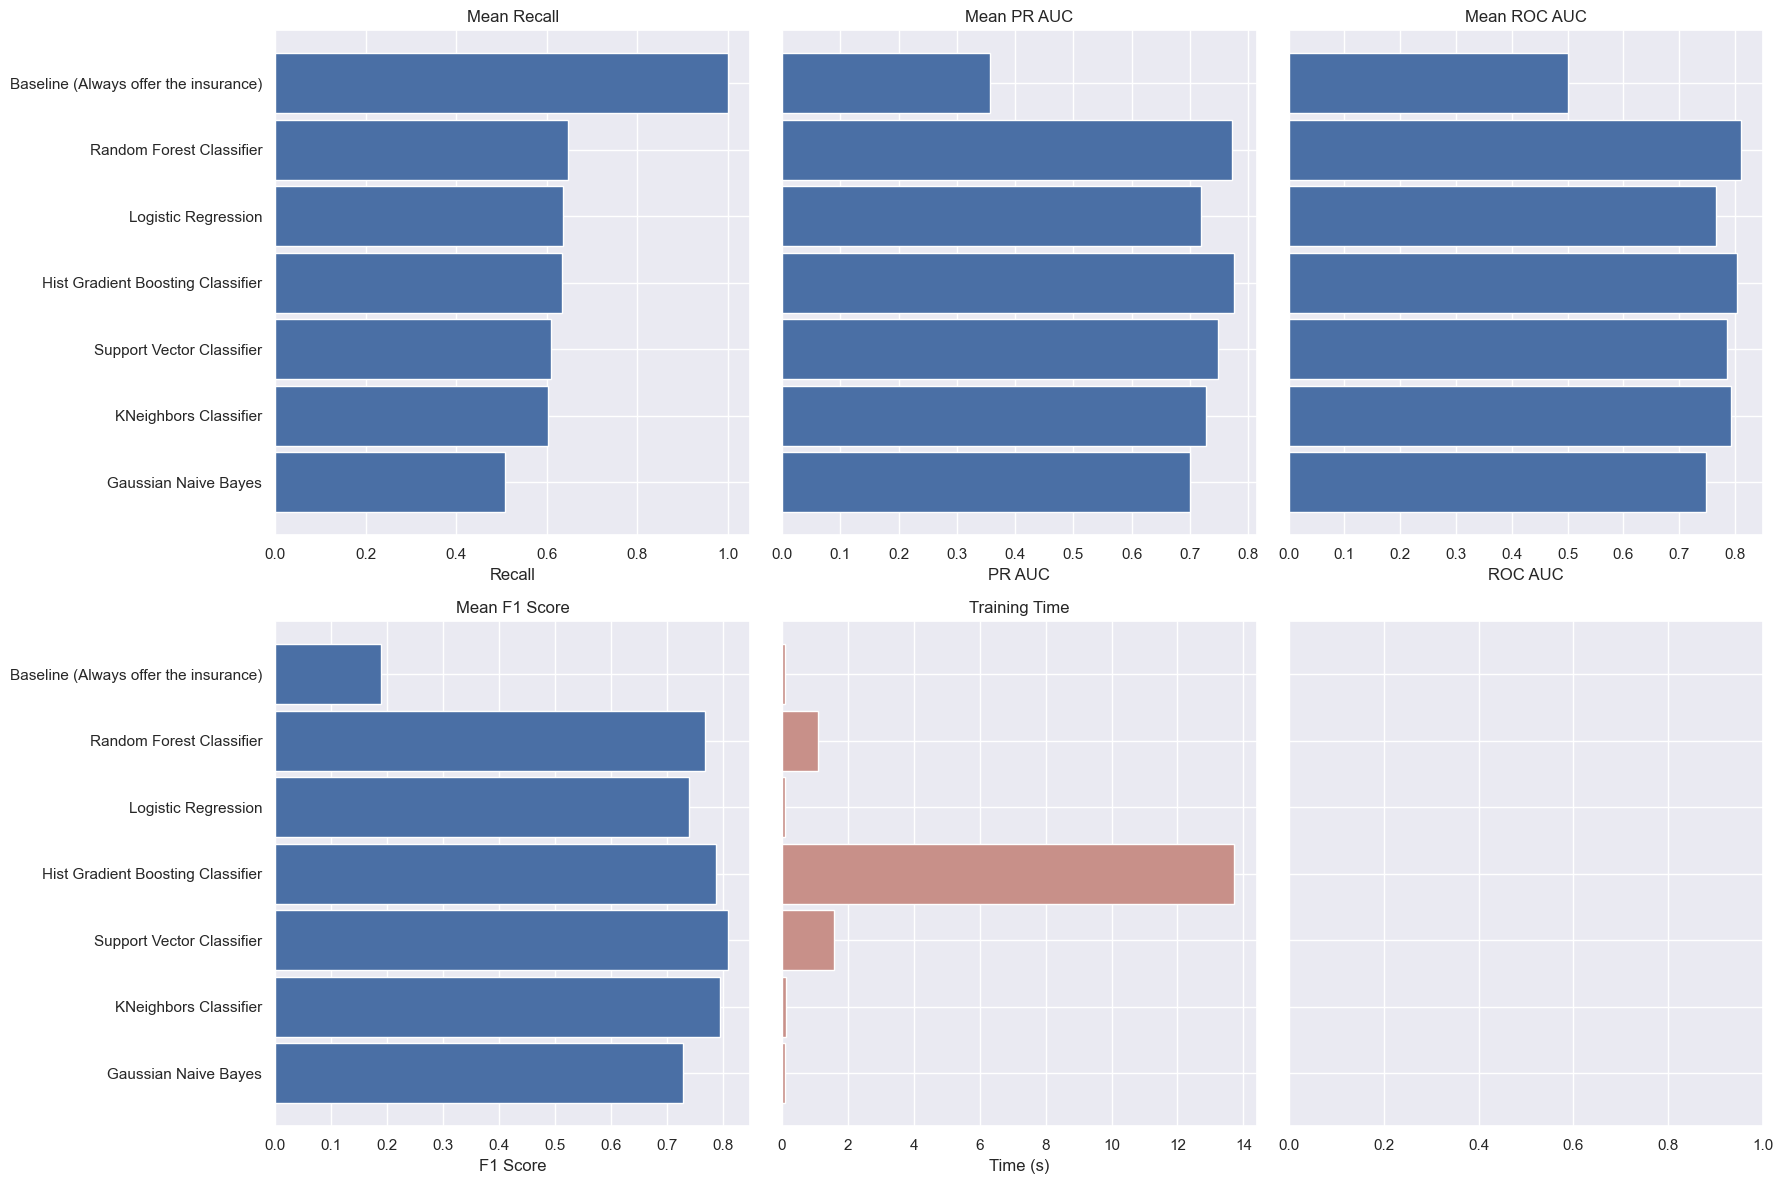

,Model,Mean Recall,Mean PR AUC,Mean ROC AUC,Mean F1 Score,Training Time (s)
0,Baseline (Always offer the insurance),1.000000,0.357457,0.500000,0.188258,0.076812
2,Random Forest Classifier,0.647896,0.772527,0.810248,0.768986,1.084426
5,Logistic Regression,0.635569,0.719314,0.765322,0.739005,0.091160
6,Hist Gradient Boosting Classifier,0.633830,0.775857,0.803519,0.787968,13.719593
1,Support Vector Classifier,0.609145,0.748860,0.785371,0.808650,1.590906
3,KNeighbors Classifier,0.603850,0.727702,0.793070,0.794390,0.113596
4,Gaussian Naive Bayes,0.507002,0.700597,0.747340,0.728545,0.077147


In [50]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

bar_width = 0.9
axes[0][0].barh(
    results_df["Model"], results_df["Mean Recall"], color=c_blue, height=bar_width
)
axes[0][0].set_title("Mean Recall")
axes[0][0].set_xlabel("Recall")
axes[0][0].invert_yaxis()

axes[0][1].barh(
    results_df["Model"], results_df["Mean PR AUC"], color=c_blue, height=bar_width
)
axes[0][1].set_title("Mean PR AUC")
axes[0][1].set_xlabel("PR AUC")

axes[0][2].barh(
    results_df["Model"], results_df["Mean ROC AUC"], color=c_blue, height=bar_width
)
axes[0][2].set_title("Mean ROC AUC")
axes[0][2].set_xlabel("ROC AUC")

axes[1][0].barh(
    results_df["Model"], results_df["Mean F1 Score"], color=c_blue, height=bar_width
)
axes[1][0].set_title("Mean F1 Score")
axes[1][0].set_xlabel("F1 Score")

axes[1][1].barh(
    results_df["Model"], results_df["Training Time (s)"], color=c_red, height=bar_width
)
axes[1][1].set_title("Training Time")
axes[1][1].set_xlabel("Time (s)")

plt.tight_layout()
plt.show()
results_df

Apart from the baseline, that wouldn't miss any potential buyer, we can see from the chart and the dataframe that the best model in terms of recall is the **Random Forest Classifier** followed by the **Logistic Regression** but there's a significant improvement in terms of the **PR AUC** score in favor of the former. The **Hist Gradient Boosting Classifier** also scores well in all metrics but its training time is 13 times higher that the time taken for training the **Random Forest Classifier**.

The decision here would need to take into account if there's any cost associated to offer the insurance to all customers:
* The **cost is negligible**: In this scenario, the best option would be to continue offering the insurance to all customers, since it is the only method that ensures that we would not miss any potential buyer, and what we want to achieve is to maximize the number of buyers.
* If on the contrary **there are associated costs**: For instance, if offering the insurance to all customers does have a bad impact on some customer's experience or at the time we offer the insurance we encourage the customer with any kind of present (which will have a cost), we may want to exclude some customers (the ones we are more sure about they won't take the offer any way) to minimize the cost for the company.

-------
Let's imagine the following scenario:
* Each **insurance offer** costs the company $1.
* If a customers pays for the insurance, the company earns $50.
* Objective: Maximize profit while ensuring the company don't miss potential buyers.

✅ **Case 1: High Recall (Trying to Capture All Buyers)**
* **Recall-focused strategy:** Contact as many customers as possible to avoid missing any buyers.
* **Outcome:**
    * **100 customers** contacted.
    * **10 actual buyers.**
    * All buyers correctly identified (**high recall**), but many non-buyers were also contacted.
* **Cost Calculation:**
    * Cost = 100 customers x $1 = $100
    * Revenue = 10 buyers x $50 = $500
    * **Profit:** $500 - $100 = **$400**

✅ **Case 2: High Precision (Targeting only likely buyers)**
* **Precision-focused strategy:** Contact fewer customers but with high confidence in their likelihood to buy.
* **Outcome:**
    * **20 customers** contacted.
    * **8 buyers correctly identified** (2 buyers were missed)
* **Cost Calculation:**
    * Cost = 20 customers x $1 = $20
    * Revenue = 8 buyers x $50 = $400
    * **Profit:** $400 - $20 = **$380**

✅ **Case 3: Balanced Precision and Recall**
* **Balanced strategy:** Target customers with a good likelihood while minimizing costs.
* **Outcome:**
    * **50 customers** contacted.
    * **9 buyers correctly identified** (1 buyer was missed)
* **Cost Calculation:**
    * Cost = 50 customers x $1 = $50
    * Revenue = 9 buyers x $50 = $450
    * **Profit:** $450 - $50 = **$400**

-----------
🎯 **Insights from the scenarios:**
* **High Recall:** captures all buyers but results in higher costs due to contacting more non-buyers.
* **High Precision:** Recudes costs but risks missing some potential buyers, leading to lost in revenue.
* **Balanced Approach:** A mix of both **precision and recall** can help balance cost-effectiveness and customer targeting.


✅ **Key Considerations:**
1. **Business impact:** Missing a few buyers may be acceptable if it saves significant outreach costs.
2. **Risk Tolerance:** If missing buyers is **critical**, focus on **Recall**.
3. **Profit Maximization:** If controlling outreach costs is key, balance **Precision and Recall** with an **F1-score**.


✅ **Recommendations:**
1. Use **Recall** as the primary metric if avoiding missed buyers is crucial.
2. Consider **Precision** and Cost-Benefit analysis to ensure the marketing campaign remains profitable.
3. The **F1-score** could be useful as a balanced metric since it considers both **Precision and Recall**.

----------------



## 6.1. Hyperparemeter tuning & Test validation

Considering that, and taking into account that the objective of the project is to practice with models, I'm going to tune the **Random Forest Classifier** to see if it is possible to improve its performance for the scenario where there's a cost associated to the offer of the insurance.

The reason for going with the **Random Forest Classifier** is that, as I mentioned in the previous section, this model scored very well in the **Recall** score and in the **PR AUC** with a much lower training time than the **Hist Gradient Boosting Classifier**. Since I'm considering the scenario where there's a cost associated with the offer, I'm going to try to improve its score in the **PR AUC** metric.

In [51]:
clf_model = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=42, class_weight="balanced"),
)

param_grid_clf = {
    "randomforestclassifier__n_estimators": np.arange(50, 250, step=50), # number of trees
    "randomforestclassifier__max_depth": [3, 5, 7],                      # Maximum depth of the tree
    "randomforestclassifier__min_samples_split": [2, 5, 10],             # Minimum samples required to split a node
    "randomforestclassifier__min_samples_leaf": [4, 5, 8]                # Minimum samples required at each leaf node
}

random_search_clf = RandomizedSearchCV(
    clf_model,
    param_distributions=param_grid_clf,
    n_iter=50,
    scoring="average_precision",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

random_search_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Annual '
                                                                                'Income']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x12aeffed0>)])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': [3,
                                                                              5,
                                                                              7],
                                        'randomforestclassifier__min_samples_leaf': [4,
                                                                                     5,
                                                                                     8],
                                        'randomforestclassifier__min_samples_split': [2,
                                                                                      5,
                                                                                      10],
                                        'randomforestclassifier__n_estimators': array([ 50, 100, 150, 200])},
                   random_state=42, scoring='average_precision')

I'll check the recall on the test set with the best estimator from above. But first I need to apply the same transformations I have applied in the training set:

In [52]:
X_test['Young Adult'] = X_test['Age'].apply(lambda x: 1 if x <= 30 else 0)
X_test['Big Family'] = X_test['Family Members'].apply(lambda x: 1 if x >= 6 else 0)
X_test.drop(columns=['Age', 'Family Members'], inplace=True)

In [53]:
from sklearn.metrics import average_precision_score

# Get the best estimator from the RandomizedSearchCV
best_model = random_search_clf.best_estimator_

# Predict probabilities for the test set
y_prob = best_model.predict_proba(X_test)[:, 1]  # Extract probabilities for the positive class

# Best hyperparameters and recall score from the training phase
print("Best Random Forest Parameters (from training):")
for key, value in random_search_clf.best_params_.items():
    print(f"\t{key}: {value}")

# Calculate Average Precision Score on the test set
average_precision_training = average_precision_score(y_train, best_model.predict_proba(X_train)[:, 1])
average_precision_test = average_precision_score(y_test, y_prob)
print(f"\nAverage Precision Score on Training Set: {average_precision_training:.4f}")
print(f"Average Precision Score on Test Set: {average_precision_test:.4f}")

Best Random Forest Parameters (from training):
	randomforestclassifier__n_estimators: 100
	randomforestclassifier__min_samples_split: 5
	randomforestclassifier__min_samples_leaf: 4
	randomforestclassifier__max_depth: 7

Average Precision Score on Training Set: 0.8352
Average Precision Score on Test Set: 0.7589


We get a 10% improvement in training set with respect of the test set, which may indicate that the model overfits the data.

Let's try increasing the dimensional space using some transformations such as `PolynomialFeatures` and `Nystroem`:

In [54]:
clf_model2 = make_pipeline(
    preprocessor,
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(random_state=42, class_weight="balanced"),
)

param_grid_clf2 = {
    "polynomialfeatures__degree": randint(2, 4),
    "randomforestclassifier__n_estimators": np.arange(50, 250, step=50), # number of trees
    "randomforestclassifier__max_depth": [3, 5, 7],                      # Maximum depth of the tree
    "randomforestclassifier__min_samples_split": [2, 5, 10],             # Minimum samples required to split a node
    "randomforestclassifier__min_samples_leaf": [4, 5, 8]                # Minimum samples required at each leaf node
}

random_search_clf2 = RandomizedSearchCV(
    clf_model2,
    param_distributions=param_grid_clf2,
    n_iter=50,
    scoring="average_precision",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

random_search_clf2.fit(X_train, y_train)

best_model_clf2 = random_search_clf2.best_estimator_

y_prob2 = best_model_clf2.predict_proba(X_test)[:, 1]

# Best hyperparameters and recall score from the training phase
print("Best Random Forest Parameters (from training):")
for key, value in random_search_clf2.best_params_.items():
    print(f"\t{key}: {value}")

# Calculate Average Precision Score on the test set
average_precision_training = average_precision_score(y_train, best_model_clf2.predict_proba(X_train)[:, 1])
average_precision_test = average_precision_score(y_test, y_prob2)
print(f"\nAverage Precision Score on Training Set: {average_precision_training:.4f}")
print(f"Average Precision Score on Test Set: {average_precision_test:.4f}")

Best Random Forest Parameters (from training):
	polynomialfeatures__degree: 3
	randomforestclassifier__max_depth: 7
	randomforestclassifier__min_samples_leaf: 4
	randomforestclassifier__min_samples_split: 5
	randomforestclassifier__n_estimators: 50

Average Precision Score on Training Set: 0.8426
Average Precision Score on Test Set: 0.7641


In [55]:
clf_model3 = make_pipeline(
    preprocessor,
    Nystroem(kernel="rbf", gamma=1, n_components=100),
    RandomForestClassifier(random_state=42, class_weight="balanced"),
)

param_grid_clf3 = {
    "nystroem__kernel": ["rbf", "poly", "linear"],
    "nystroem__gamma": uniform(0.01, 1),
    "nystroem__n_components": randint(50, 300),
    "randomforestclassifier__n_estimators": np.arange(50, 250, step=50), # number of trees
    "randomforestclassifier__max_depth": [3, 5, 7],                      # Maximum depth of the tree
    "randomforestclassifier__min_samples_split": [2, 5, 10],             # Minimum samples required to split a node
    "randomforestclassifier__min_samples_leaf": [4, 5, 8]                # Minimum samples required at each leaf node
}

random_search_clf3 = RandomizedSearchCV(
    clf_model3,
    param_distributions=param_grid_clf3,
    n_iter=50,
    scoring="average_precision",
    cv=5,
    random_state=42,
    n_jobs=-1,
)

random_search_clf3.fit(X_train, y_train)

best_model_clf3 = random_search_clf3.best_estimator_

y_prob3 = best_model_clf3.predict_proba(X_test)[:, 1]

# Best hyperparameters and recall score from the training phase
print("Best Random Forest Parameters (from training):")
for key, value in random_search_clf3.best_params_.items():
    print(f"\t{key}: {value}")

# Calculate Average Precision Score on the test set
average_precision_training = average_precision_score(y_train, best_model_clf3.predict_proba(X_train)[:, 1])
average_precision_test = average_precision_score(y_test, y_prob3)
print(f"\nAverage Precision Score on Training Set: {average_precision_training:.4f}")
print(f"Average Precision Score on Test Set: {average_precision_test:.4f}")

Best Random Forest Parameters (from training):
	nystroem__gamma: 0.6554722959071678
	nystroem__kernel: rbf
	nystroem__n_components: 221
	randomforestclassifier__max_depth: 5
	randomforestclassifier__min_samples_leaf: 4
	randomforestclassifier__min_samples_split: 5
	randomforestclassifier__n_estimators: 50

Average Precision Score on Training Set: 0.8570
Average Precision Score on Test Set: 0.7617


Applying a polynomial transformation to the dataset increases the average precision by 0.8% but also seems to make the model less likely to overfit since the difference between the score for the training set and test set has also reduced.

# 7. Conclusions and Improvements

## 7.1. Conclusions
Throughout this project, I have explored the Travel Insurance dataset with a focus on predicting the likelihood of a customer purchasing travel insurance. The process involved comprehensive data analysis, statistical inference, and the application of multiple machine learning models.

Key findings include:

* **Exploratory Data Analysis:**  Identified significant patterns and correlations among features, including the influence of Employment Type, Frequent Flyer, and Annual Income on the target variable.
* **Statistical Testing:** Hypotheses tests revealed significant differences in the annual income across younger adults and older adults, with older adults earning more on average. The other two tests revealed that there's no significant difference, at least not at 5% significance level, between the groups within the features `Graduate Or Not` and `Chronic Diseases` when it comes to purchasing the insurance.
* **Machine Learning Models:** Various models were evaluated, including Logistic Regression, Support Vector Classifier (SVC), and Gradient Boosting models. After hyperparameter tuning and feature engineering, the final model was a **Random Forest Classifiern** with preprocessing and data transformation steps to increase dimensionality, achieved an average precision of 76.41% on the test set. In a real scenario, if the cost of offering all customers the insurance is not high, I would opt for that option since it ensures that the company does not miss any customer.

## 7.2. Recommendations for Improvement
* **Dataset Scope and Representation:** The dataset focuses on a limited customer range, with `Age` spanning only from **25 to 35 years**. To ensure results can be generalized across the entire customer base, it is important to verify whether this subset is representative of the full population. If not, future studies should expand the age range and customer diversity for broader insights.
* **Model Selection and Business Needs:** When selecting models, it is crucial to balance **accuracy, training time, and interpretability** based on the company's priorities:
    * If **higher accuracy** (or recall in this case) is a priority, more complex models (like Gradient Boosting or Neural Networks) could be considered despite longer training times.
    * If **explainability** is important, simpler models such as Logistic Regression are preferable, as they allow for better understanding of feature importance and decision-making patterns.
     * A more detailed cost-benefit analysis can help the company determine whether optimizing accuracy or model transparency better aligns with their business objectives.